<a href="https://colab.research.google.com/github/EnochYounceSAIC/colab/blob/main/weektwo/channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
length = 3000
span = 100
sps = 100
lambda_light = 1550e-9
f_light = 3e8/lambda_light
#fiber data sheet used : https://www.corning.com/media/worldwide/coc/documents/Fiber/product-information-sheets/PI-1470-AEN.pdf
dispersion = 18 #ps/nm/km
distance = np.arange(0,length,1)

In [88]:
#This code is AI- assisted and is used for the generation of psuedorandom data to test the dispersion
def gen_random_data(type, amount):
  if type == '16qam':
    # 1. Generate random bits
    random_bits = np.random.randint(0, 2, 4*amount)

    # 2. Reshape into groups of 4 bits
    bit_groups = random_bits.reshape(-1, 4)

    # 3. Map 4-bit groups to 16-QAM constellation points
    # Define the 16-QAM constellation mapping
    qam16_mapping = {
        (0, 0, 0, 0): -3 - 3j, (0, 0, 0, 1): -3 - 1j, (0, 0, 1, 0): -3 + 3j, (0, 0, 1, 1): -3 + 1j,
        (0, 1, 0, 0): -1 - 3j, (0, 1, 0, 1): -1 - 1j, (0, 1, 1, 0): -1 + 3j, (0, 1, 1, 1): -1 + 1j,
        (1, 0, 0, 0):  3 - 3j, (1, 0, 0, 1):  3 - 1j, (1, 0, 1, 0):  3 + 3j, (1, 0, 1, 1):  3 + 1j,
        (1, 1, 0, 0):  1 - 3j, (1, 1, 0, 1):  1 - 1j, (1, 1, 1, 0):  1 + 3j, (1, 1, 1, 1):  1 + 1j
    }

    qam16_symbols = np.array([qam16_mapping[tuple(group)] for group in bit_groups])
    return qam16_symbols
  elif type == 'qpsk':
    # 1. Generate random bits
    random_bits_qpsk = np.random.randint(0, 2, 2*amount)

    # 2. Reshape into groups of 2 bits
    bit_groups_qpsk = random_bits_qpsk.reshape(-1, 2)

    # 3. Map 2-bit groups to QPSK constellation points
    # Define the QPSK constellation mapping
    qpsk_mapping = {
        (0, 0): -1 - 1j,
        (0, 1): -1 + 1j,
        (1, 0):  1 - 1j,
        (1, 1):  1 + 1j
    }

    qpsk_symbols = np.array([qpsk_mapping[tuple(group)] for group in bit_groups_qpsk])
    return qpsk_symbols
  elif type == 'bpsk':
    # 1. Generate random bits (0 or 1)
    random_bits_bpsk = np.random.randint(0, 2, amount)

    # 2. Map these bits to BPSK constellation points: 0 maps to -1, and 1 maps to 1.
    # This can be done by multiplying by 2 and subtracting 1: 0*2 - 1 = -1, 1*2 - 1 = 1
    bpsk_symbols = 2 * random_bits_bpsk - 1

In [89]:
def shape_signal(data,sps):
  #RRC
  fs = 4
  num_weights = 41
  alpha = 0.3
  x = 0.9999*np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/fs
  raised_cos_weights = np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))

  #pulse shaping
  # 1. Upsample the symbols by inserting zeros
  upsampled_symbols = np.zeros(len(data) * sps, dtype=complex)
  upsampled_symbols[::sps] = data

  # 2. Convolve the upsampled signal with the raised_cos_weights filter.
  shaped_signal = np.convolve(upsampled_symbols, raised_cos_weights, mode='full')
  return shaped_signal

Im going to try to apply channels, we will see if it works

In [90]:
channels = 70
signal_length = 500
channeled_lambdas = np.zeros(channels)
signals = np.zeros((channels, signal_length), dtype=complex)


for i in range(channels):
  channeled_lambdas[i] = lambda_light - i*0.3e-9
  signals[i] = gen_random_data('16qam', signal_length)

In [91]:


# Generate and shape the signal for each channel
multi_channel_signal = np.zeros((channels, signal_length * sps + num_weights - 1), dtype=complex)
time_vector = np.arange(multi_channel_signal.shape[1]) / (sps * 1) # Assuming a symbol rate of 1 for the time vector

for i in range(channels):
    # Generate random data for the channel
    channel_data = gen_random_data('16qam', signal_length)
    # Shape the signal
    shaped_channel_signal = shape_signal(channel_data, sps)

    # Calculate the carrier frequency for this channel
    carrier_frequency = 3e8 / channeled_lambdas[i]

    # Create the carrier wave (complex exponential)
    carrier_wave = np.exp(1j * 2 * np.pi * carrier_frequency * time_vector[:len(shaped_channel_signal)])

    # Modulate the shaped signal onto the carrier
    multi_channel_signal[i, :len(shaped_channel_signal)] = shaped_channel_signal * carrier_wave

print(multi_channel_signal.shape)

(70, 50040)


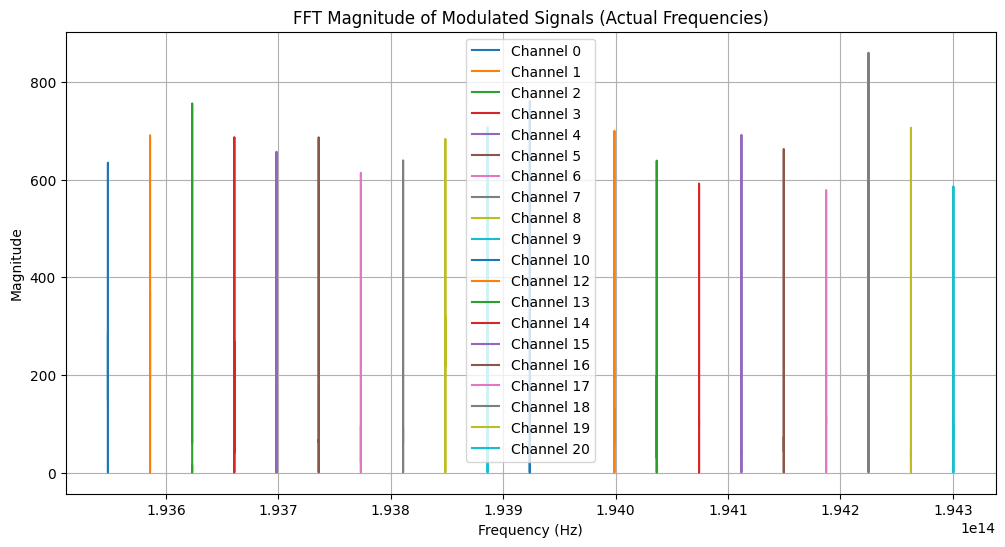

In [92]:
# Select different channels to plot
channel_indices_to_plot = [0, 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]


plt.figure(figsize=(12, 6))

# Calculate the sampling frequency based on the time vector and its length
# The time vector is created with a step of 1/(sps * 1), so the sampling rate is sps * 1
sampling_rate = sps * 1
n_samples = multi_channel_signal.shape[1]
frequency_resolution = sampling_rate / n_samples

for channel_index in channel_indices_to_plot:
    signal = multi_channel_signal[channel_index]
    fft_signal = np.fft.fft(signal)
    carrier_frequency = 3e8 / channeled_lambdas[channel_index]

    frequencies_relative = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    frequencies_actual = frequencies_relative + carrier_frequency

    plt.plot(np.fft.fftshift(frequencies_actual), np.abs(np.fft.fftshift(fft_signal)), label=f'Channel {channel_index}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT Magnitude of Modulated Signals (Actual Frequencies)')
plt.legend()
plt.grid(True)
plt.show()